### Data file: credit_cards.csv

### Step 1: Import libraries and dataset

In [1]:
#import libraries
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('projectcluster').getOrCreate()

In [2]:
#import the dataset
credit_card = spark.read.csv('credit_cards.csv',header=True,inferSchema=True)

### Step 2: Explore the dataset

In [3]:
#print schema
credit_card.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [4]:
#print column name
credit_card.columns

['CUST_ID',
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [5]:
#descriptive statistics
credit_card.describe().show()

+-------+-------+------------------+-------------------+------------------+------------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+
|summary|CUST_ID|           BALANCE|  BALANCE_FREQUENCY|         PURCHASES|  ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|      CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|  CASH_ADVANCE_TRX|     PURCHASES_TRX|     CREDIT_LIMIT|          PAYMENTS| MINIMUM_PAYMENTS|  PRC_FULL_PAYMENT|           TENURE|
+-------+-------+------------------+-------------------+------------------+------------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+------------------+--

In [6]:
#count and print total rows
total_rows = credit_card.count()
print("Total Rows: ", total_rows)

Total Rows:  8950


In [7]:
#count and print total columns
total_columns= len(credit_card.columns)
print("Total Columns: ", total_columns)

Total Columns:  18


In [8]:
#find the missing values
from pyspark.sql.functions import isnan, when, count, col

missing_values = credit_card.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in credit_card.columns]).toPandas()
print(missing_values)

   CUST_ID  BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0        0        0                  0          0                 0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                       0             0                    0   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                           0                                 0   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                       0                 0              0             1   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0         0               313                 0       0  


In [9]:
#drop missing data
new_ccdata = credit_card.na.drop()

In [10]:
#count total rows for new data
total_rows = new_ccdata.count()
print("Total Rows: ", total_rows)

Total Rows:  8636


### Step 3: Find which feature is most significant using either Decision tree or Random Forest

#### Step 3.1 : Transform and standarized the columns

In [11]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

#all columns used to find the significant columns 
col= ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

#create features column
assembler = VectorAssembler(inputCols=col, outputCol='features')

# Define the StandardScaler transformer
scaler = StandardScaler(inputCol='features', outputCol='scaled_features',
                        withMean=True, withStd=True)

In [12]:
#use pipeline to process data
pipeline = Pipeline(stages=[assembler, scaler])
output = pipeline.fit(new_ccdata).transform(new_ccdata)

23/05/05 22:33:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [13]:
# Show the first  rows of the transformed data
output.head()

Row(CUST_ID='C10001', BALANCE=40.900749, BALANCE_FREQUENCY=0.818182, PURCHASES=95.4, ONEOFF_PURCHASES=0.0, INSTALLMENTS_PURCHASES=95.4, CASH_ADVANCE=0.0, PURCHASES_FREQUENCY=0.166667, ONEOFF_PURCHASES_FREQUENCY=0.0, PURCHASES_INSTALLMENTS_FREQUENCY=0.083333, CASH_ADVANCE_FREQUENCY=0.0, CASH_ADVANCE_TRX=0, PURCHASES_TRX=2, CREDIT_LIMIT=1000.0, PAYMENTS=201.802084, MINIMUM_PAYMENTS=139.509787, PRC_FULL_PAYMENT=0.0, TENURE=12, features=DenseVector([40.9007, 0.8182, 95.4, 0.0, 95.4, 0.0, 0.1667, 0.0, 0.0833, 0.0, 0.0, 2.0, 1000.0, 201.8021, 139.5098, 0.0, 12.0]), scaled_features=DenseVector([-0.7446, -0.37, -0.4292, -0.3591, -0.3548, -0.4686, -0.8207, -0.6862, -0.7171, -0.6819, -0.4794, -0.5176, -0.9625, -0.5439, -0.3055, -0.5377, 0.3552]))

In [14]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='scaled_features', k=2)
model = kmeans.fit(output)
cluster = model.transform(output)

In [16]:
#add prediction to the data frame 
from pyspark.sql.functions import col

cluster = cluster.select(col("CUST_ID"), col("prediction").alias("cluster"))

# Join the predicted cluster column to the original DataFrame using the ID column as the join key
credit_card_clustered = output.join(cluster, "CUST_ID")


In [18]:
dt_data = credit_card_clustered.select('scaled_features','cluster')

In [19]:
#splitting the data 
train_data,test_data = dt_data.randomSplit([0.7,0.3])

#### 3.2 Build decision tree and random forest models

In [20]:
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier

In [21]:
dtc = DecisionTreeClassifier(labelCol='cluster',featuresCol='scaled_features')
rfc = RandomForestClassifier(labelCol='cluster',featuresCol='scaled_features')

In [22]:
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)

In [23]:
dtc_preds = dtc_model.transform(test_data)
rfc_preds = rfc_model.transform(test_data)

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [25]:
# default metricName: areaUnderROC, other metricName: areaUnderPR
my_binary_eval = BinaryClassificationEvaluator(labelCol='cluster')

In [26]:
print('DTC area under ROC: %f' % my_binary_eval.evaluate(dtc_preds))
print('RFC area under ROC: %f' % my_binary_eval.evaluate(rfc_preds))

DTC area under ROC: 0.820421
RFC area under ROC: 0.994465


In [27]:
# show accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [28]:
acc_eval = MulticlassClassificationEvaluator(labelCol='cluster',
                                            metricName='accuracy')

In [29]:
print("dtc accuracy: %f " % acc_eval.evaluate(dtc_preds))
print("rfc accuracy: %f " % acc_eval.evaluate(rfc_preds))

dtc accuracy: 0.955865 
rfc accuracy: 0.967867 


###### We could see that ROC and the Accuracy of Random Forest Tree is higher than  Decision tree. So we will be relying the result of random forest to select the significant features.

In [30]:
display(rfc_model)

RandomForestClassificationModel: uid=RandomForestClassifier_70dabb5bdc0d, numTrees=20, numClasses=2, numFeatures=17

In [31]:
rfc_model.featureImportances

SparseVector(17, {0: 0.1723, 1: 0.0008, 2: 0.0055, 3: 0.0009, 4: 0.0021, 5: 0.2498, 6: 0.0031, 7: 0.0008, 8: 0.0023, 9: 0.2579, 10: 0.1942, 11: 0.0087, 12: 0.0461, 13: 0.0073, 14: 0.0456, 15: 0.0027, 16: 0.0001})

###### To determine which features are most significant, I look at the importance scores of the features in Random Forest model. These scores represent the relative importance of each feature in making accurate predictions. I will be selecting top 10 scores and their variables as my features for my K Means model

### Step 4: Used columns based on the random forest importance score as features for K - Means model

In [32]:
#columns used as features based on Random Forest importance score
col= ['BALANCE','PURCHASES', 'CASH_ADVANCE','PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

#create features column
assembler = VectorAssembler(inputCols=col, outputCol='features')

# Define the StandardScaler transformer
scaler = StandardScaler(inputCol='features', outputCol='scaled_features',
                        withMean=True, withStd=True)

In [33]:
#use pipeline to process data
pipeline = Pipeline(stages=[assembler, scaler])
output = pipeline.fit(new_ccdata).transform(new_ccdata)

### Step 5: Train a k-means model

In [35]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='scaled_features', k=2)
model = kmeans.fit(output)

In [36]:
#shows the total number of customer in each cluster
model.transform(output).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1551|
|         0| 7085|
+----------+-----+



### Step 6: Evaluate clustering by computing SSE, silhouette, and centroids

In [37]:
from pyspark.ml.evaluation import ClusteringEvaluator

#calculating wsse score
wssse = model.summary.trainingCost
print('Within-Cluster Sum of Squares:'+ str(wssse))

Within-Cluster Sum of Squares:68100.87719212462


In [38]:
#calculating Silhouette Score
predict = model.transform(output)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predict)
print('Silhouette Score:'+ str(silhouette))

Silhouette Score:0.6038256831453686


In [39]:
#show the center of the cluster
centers = model.clusterCenters()
print("Cluster centers: ")
for center in centers:
    print(center)

Cluster centers: 
[-0.30905552 -0.04949845 -0.30087057  0.06994289 -0.31234929 -0.28422833
 -0.02098307 -0.19973955 -0.18079676 -0.13357921]
[ 1.41177201  0.22610995  1.37438299 -0.31950056  1.42681798  1.29836087
  0.0958511   0.9124144   0.82588332  0.61019257]


### Step 7: Compute wssse and silhouette scores for different k values

In [40]:
range_k = [2,3,4,5,6,7,8,9,10]

In [41]:
#evaluate wssse score and silhouette score for k 2-10
wssse_scores = []
silhouette_scores = []
for k in range_k:
    kmeans = KMeans(featuresCol='scaled_features',k=k)
    model = kmeans.fit(output) 
    predict = model.transform(output)
    wssse = model.summary.trainingCost
    wssse_scores.append(wssse)
    silhouette = evaluator.evaluate(predict)
    silhouette_scores.append(silhouette)

In [42]:
#print wssse
print("within-set sum of squared errors: ")
i=0
while i<9:
    print(range_k[i], wssse_scores[i])
    i=i+1

within-set sum of squared errors: 
2 68100.87719212462
3 57411.2461438865
4 50369.245419598155
5 46933.528916663076
6 41929.49830491787
7 38317.576606975876
8 38669.83129557763
9 33477.54562689275
10 33629.236575322015


In [43]:
#print the silhouette score
print("silhouette coefficients: ")
i=0
while i<9:
    print(range_k[i], silhouette_scores[i])
    i=i+1

silhouette coefficients: 
2 0.6038256831453686
3 0.5174452036429469
4 0.03472576817512927
5 0.09756521027301389
6 0.01836672533230017
7 0.006134707151443678
8 0.03540825991883549
9 0.0265941014949841
10 0.03096580702493428


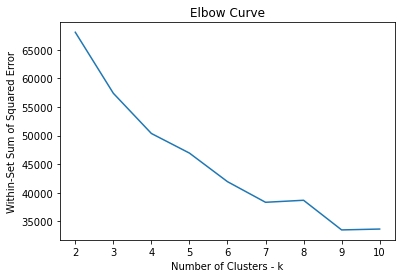

In [44]:
# Plot the elbow curve using Python matplotlib library
import matplotlib.pyplot as plt
import numpy as np
plt.plot(range_k,wssse_scores)
plt.ylabel('Within-Set Sum of Squared Error')
plt.xlabel('Number of Clusters - k')
plt.title('Elbow Curve')
plt.show()

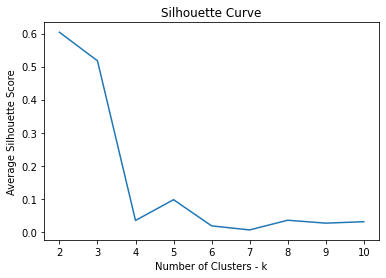

In [45]:
#plot the silhouette curve using Python matplotlib library
plt.plot(range_k,silhouette_scores)
plt.ylabel('Average Silhouette Score')
plt.xlabel('Number of Clusters - k')
plt.title('Silhouette Curve')
plt.show()

### Conclusion

###### Based on these two curve, my k value would be 3. As you can see that in the elbow curve the value of the wssse decreases rapidly from 2 to 3 and after 3 it levels off. Also when we look at the silhouette curve, the average sihouette score is highest at k=2 followed by k =3, so I will be using 3 as the value of k for this problem

In [46]:
#using k = 3
kmeans = KMeans(featuresCol='scaled_features', k=3)
model = kmeans.fit(output)

#calculating wsse score
wssse = model.summary.trainingCost
print('Within-Cluster Sum of Squares:'+ str(wssse))

#calculating Silhouette Score
predict = model.transform(output)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predict)
print('Silhouette Score:'+ str(silhouette))

Within-Cluster Sum of Squares:57411.2461438865
Silhouette Score:0.5174452036429469


In [47]:
#show the center of the cluster
centers = model.clusterCenters()
print("Cluster centers: ")
for center in centers:
    print(center)

Cluster centers: 
[-0.341606   -0.16913917 -0.30780084  0.01403815 -0.33134886 -0.29802602
 -0.17201428 -0.27510797 -0.25389584 -0.13131447]
[ 1.18552728 -0.25740563  1.45265784 -0.57018396  1.62188104  1.42694763
 -0.31492085  0.6409006   0.50670564  0.37590999]
[ 0.69904585  2.23104222 -0.22832995  1.1353281  -0.37546879 -0.26666598
  2.38758915  1.26356436  1.35538667  0.44687491]


In [48]:
#shows the total number of customer in each cluster
model.transform(output).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1480|
|         2|  663|
|         0| 6493|
+----------+-----+



### New strategy improvement

###### Although we set k as 3 to create clusters, I was dissatisfied with the outcome. Specifically, I was not pleased with the fact that 2 of the clusters had a significant number of samples, i.e., over 2000, while the other one had less than 1000 samples. I believe that if we use the mean value of Minimum_payments" and "credit_limit," to replace all the null values, we will have more samples and build a more precise model. 

In [49]:
#replacing the missing values in the Credit_limit column with mean value
from pyspark.sql.functions import mean

mean_value = credit_card.select(mean('CREDIT_LIMIT')).collect()[0][0]
credit_card = credit_card.fillna({'CREDIT_LIMIT': mean_value})

In [50]:
#replacing the missing values in the minimum_payments column with mean value
mean_value = credit_card.select(mean('MINIMUM_PAYMENTS')).collect()[0][0]
credit_card = credit_card.fillna({'MINIMUM_PAYMENTS': mean_value})

In [51]:
new_data = credit_card

In [52]:
#columns used as features excluding the columns with missing values
col= ['BALANCE','PURCHASES', 'CASH_ADVANCE','PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

assembler = VectorAssembler(inputCols=col, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features',
                        withMean=True, withStd=True)

In [53]:
#use pipeline to process data
pipeline = Pipeline(stages=[assembler, scaler])
output = pipeline.fit(new_data).transform(new_data)

In [54]:
range_k = [2,3,4,5,6,7,8,9,10]

In [55]:
#evaluate wssse score and silhouette score for k 2-10
wssse_scores = []
silhouette_scores = []
for k in range_k:
    kmeans = KMeans(featuresCol='scaled_features',k=k)
    model = kmeans.fit(output) 
    predict = model.transform(output)
    wssse = model.summary.trainingCost
    wssse_scores.append(wssse)
    silhouette = evaluator.evaluate(predict)
    silhouette_scores.append(silhouette)

In [56]:
#print wssse
print("within-set sum of squared errors: ")
i=0
while i<9:
    print(range_k[i], wssse_scores[i])
    i=i+1

within-set sum of squared errors: 
2 70591.86600964768
3 59535.158906499506
4 52235.71113948068
5 47504.00601839567
6 43544.61713076185
7 39875.41513671522
8 38426.74119663404
9 35233.569765697976
10 36834.4650214048


In [57]:
#print the silhouette score
print("silhouette coefficients: ")
i=0
while i<9:
    print(range_k[i], silhouette_scores[i])
    i=i+1

silhouette coefficients: 
2 0.6122426947064683
3 0.5226805888078345
4 0.03630323823590832
5 0.046501811111464716
6 0.03527500154538027
7 0.014167677480547076
8 0.0031979113456988674
9 -0.0008834579535662297
10 -0.0003466284440605645


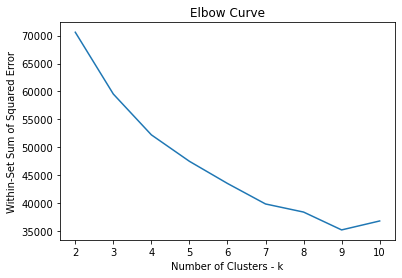

In [58]:
# Plot the elbow curve using Python matplotlib library
import matplotlib.pyplot as plt
import numpy as np
plt.plot(range_k,wssse_scores)
plt.ylabel('Within-Set Sum of Squared Error')
plt.xlabel('Number of Clusters - k')
plt.title('Elbow Curve')
plt.show()

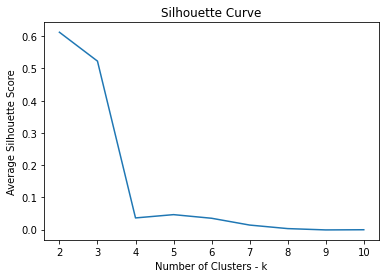

In [59]:
#plot the silhouette curve using Python matplotlib library
plt.plot(range_k,silhouette_scores)
plt.ylabel('Average Silhouette Score')
plt.xlabel('Number of Clusters - k')
plt.title('Silhouette Curve')
plt.show()

###### After analyzing the two curves, I have determined that the optimal value for k is 3. The elbow curve indicates a significant decrease in the value of wssse from k=2 to k=3, after which it starts to level off. Similarly, the silhouette curve indicates that the average silhouette score is highest at k=2 followed by K=3 . 

In [60]:
#using k = 3
kmeans = KMeans(featuresCol='scaled_features', k=3)
model = kmeans.fit(output)

#calculating wsse score
wssse = model.summary.trainingCost
print('Within-Cluster Sum of Squares:'+ str(wssse))

#calculating Silhouette Score
predict = model.transform(output)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predict)
print('Silhouette Score:'+ str(silhouette))

Within-Cluster Sum of Squares:59535.158906499506
Silhouette Score:0.5226805888078345


In [61]:
#show the center of the cluster
centers = model.clusterCenters()
print("Cluster centers: ")
for center in centers:
    print(center)

Cluster centers: 
[-0.34115911 -0.1689853  -0.30526909  0.0103116  -0.32889691 -0.29515816
 -0.17144521 -0.27156483 -0.2507837  -0.12875576]
[ 0.71656125  2.25622397 -0.22358861  1.14752513 -0.36595105 -0.26049723
  2.41328264  1.26668289  1.37733342  0.44860956]
[ 1.20644714 -0.24813097  1.46418723 -0.55653144  1.63314192  1.43540279
 -0.30699527  0.65061926  0.50849674  0.37606725]


In [62]:
#shows the total number of customer in each cluster
model.transform(output).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  673|
|         2| 1513|
|         0| 6764|
+----------+-----+



###### In this study, the KMeans clustering algorithm was evaluated using two different models, one with 3 clusters and removing all the missing values rows and the other with 3 clusters with replacing the missig values with mean values. The results indicated that the model with 3 clusters and replacing the missing vlaues with the mean values performed better than the model with 3 clusters with removing the missing values.